In [161]:
from sklearn.metrics import plot_roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt

## **Importing dataes**

In [162]:
with open('./vals.txt', 'r') as vals_opn: #GARLIC SCORES
    for line in vals_opn:
        
        vals = eval(line)   
            
with open('./real.txt', 'r') as real_opn: #GARLIC CLASEES
    for line in real_opn:
        
        real = eval(line)
        
with open('./features.txt', 'r') as features_opn: #BioCAT SCORES
    for line in features_opn:
        
        features = eval(line)
        
with open('./labels.txt', 'r') as labels_opn: #BioCAT CLASEES
    for line in labels_opn:
        
        labels = eval(line)


## **Iterations for every samples**

In [163]:
iterations = 1000

## **Learning logistic regression to GARLIC data**

In [164]:
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve
from sklearn.metrics import matthews_corrcoef 
mean_fpr = np.linspace(0, 1, 100)
sss = StratifiedShuffleSplit(n_splits=iterations, test_size=0.2)
#For logistic gergression of Garlic 
logisticRegr = LogisticRegression()
tprs_Garlic = []
aucs_Garlic = []
#For Precission Recall curve
recalls_dict_Garlic = {}
PR_aucs_Garlic = []
#For Random forest of BioCAT
rfr = RandomForestClassifier(                            
#                            n_estimators=500,
                            max_features='sqrt',
                            class_weight='balanced',
                            #criterion='gini',
   #                         max_leaf_nodes=50,
  #                          min_weight_fraction_leaf=0.0001,
                            min_samples_split=10,
                            max_depth=6
)

#For Precission Recall curve
recalls_dict_BioCAT = {}
PR_aucs_BioCAT = []
#ROC curve data maning

#Precission recall curve data maning

precision_T = []
recall_T = []
f1_score_T = []
precision_F = []
recall_F = []
f1_score_F = []
matthews_corrcoef_T = []

#Garlic
vals = np.array(vals)
real = np.array(real)
sss.get_n_splits(vals, real)
for train_index, test_index in sss.split(vals, real):

    
    #LogitRegr
    x_train, x_test = vals[train_index], vals[test_index]
    y_train, y_test = real[train_index], real[test_index]
    logisticRegr.fit(x_train, y_train) #learning model
    prediction = logisticRegr.predict_proba(x_test)
    
    precision_T.append(classification_report(logisticRegr.predict(x_test), y_test, output_dict=True)['1']['precision'])
    recall_T.append(classification_report(logisticRegr.predict(x_test), y_test, output_dict=True)['1']['recall'])
    f1_score_T.append(classification_report(logisticRegr.predict(x_test), y_test, output_dict=True)['1']['f1-score'])
    precision_F.append(classification_report(logisticRegr.predict(x_test), y_test, output_dict=True)['0']['precision'])
    recall_F.append(classification_report(logisticRegr.predict(x_test), y_test, output_dict=True)['0']['recall'])
    f1_score_F.append(classification_report(logisticRegr.predict(x_test), y_test, output_dict=True)['0']['f1-score'])
    matthews_corrcoef_T.append(matthews_corrcoef(logisticRegr.predict(x_test), y_test))
    
    pred = []
    [pred.append(i[1]) for i in prediction]
    
    #Garlic ROC
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_Garlic.append(interp_tpr)
    aucs_Garlic.append(roc_auc)    
   

    prec, recall, _ = precision_recall_curve(y_test, logisticRegr.predict_proba(x_test)[:,1],
                                             pos_label=logisticRegr.classes_[1]
                                            )
    PR_aucs_Garlic.append(auc(recall, prec))
    #Adding pairs recall/precision
    for rec in recall:

        if rec not in recalls_dict_Garlic:
            recalls_dict_Garlic[rec] = []

        recalls_dict_Garlic[rec].extend(list(prec[np.where(recall == rec)]))
#BioCAT
X = features
y = labels
tprs_BioCAT = []
aucs_BioCAT = []
X = np.array(X)
y = np.array(y)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    #RF ROC
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rfr.fit(X_train, y_train)
    prediction = rfr.predict_proba(X_test)    
    pred = []
    #BioCAT ROC
    [pred.append(i[1]) for i in prediction]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_BioCAT.append(interp_tpr)
    aucs_BioCAT.append(roc_auc)
        
    prec, recall, _ = precision_recall_curve(y_test, rfr.predict_proba(X_test)[:,1],
                                            pos_label=rfr.classes_[1]
                                            )

    for rec in recall:
        if rec not in recalls_dict_BioCAT:
            recalls_dict_BioCAT[rec] = []

        recalls_dict_BioCAT[rec].extend(list(prec[np.where(recall == rec)]))
        
    PR_aucs_BioCAT.append(auc(recall, prec))


## **Darawing**

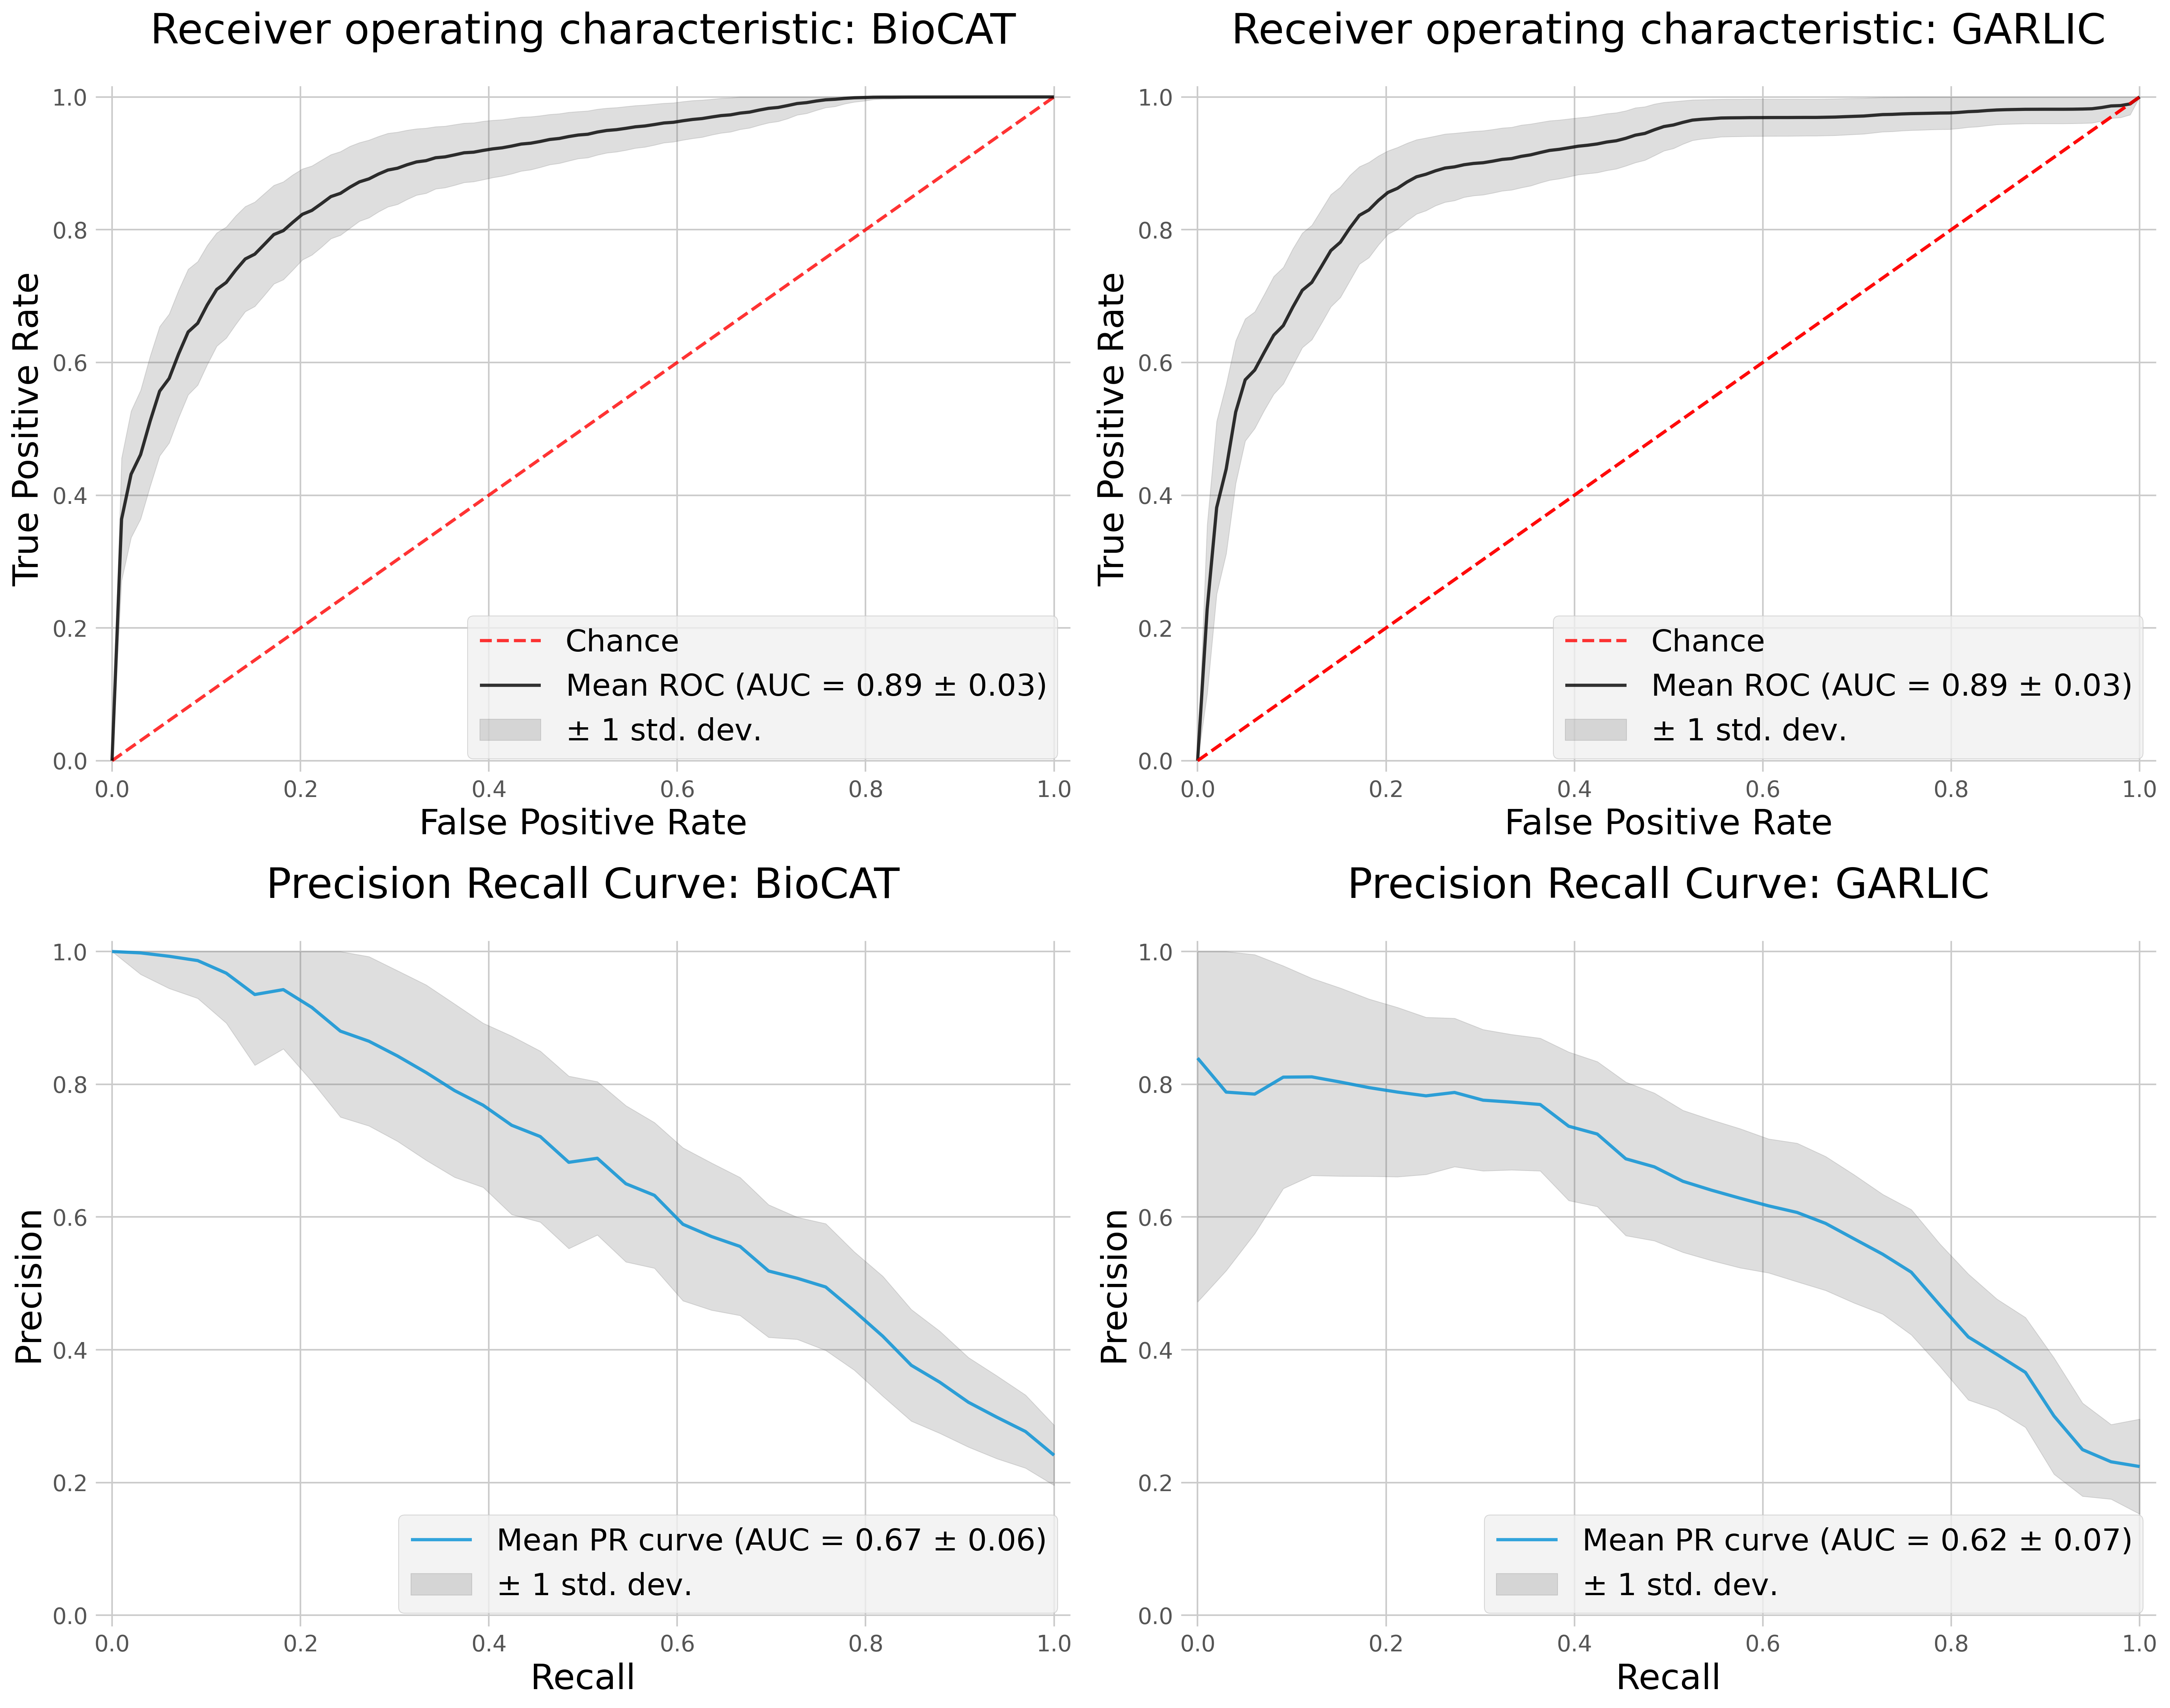

In [165]:
#MPL styles
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
fig, axs = plt.subplots(2, 2, figsize=(19, 15), dpi=300, facecolor='white')
axs[0][0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='red',
        label='Chance', alpha=.8)
#ROC curve
#BioCAT
mean_tpr = np.mean(tprs_BioCAT, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_BioCAT)
axs[0][0].plot(mean_fpr, mean_tpr, color='black',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

std_tpr = np.std(tprs_BioCAT, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
axs[0][0].fill_between(mean_fpr, tprs_lower, tprs_upper, 
                       color='#5D5D5D', alpha=.2,
                       label=r'$\pm$ 1 std. dev.')
axs[0][0].set_title("Receiver operating characteristic: BioCAT", fontsize=26, pad=25)
axs[0][0].set_ylabel('True Positive Rate', fontsize=22, color='black')
axs[0][0].set_xlabel('False Positive Rate', fontsize=22, color='black')
axs[0][0].legend(loc='lower right', fontsize=19)
axs[0][0].set_facecolor('white')
axs[0][0].set_ylim([-0.02, 1.02])
axs[0][0].set_xlim([-0.02, 1.02])
#Garlic
mean_tpr = np.mean(tprs_Garlic, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_Garlic)
axs[0][1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='red',
        label='Chance', alpha=.8)
axs[0][1].plot(mean_fpr, mean_tpr,color='black',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

std_tpr = np.std(tprs_Garlic, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
axs[0][1].fill_between(mean_fpr, tprs_lower, tprs_upper, 
                       color='#5D5D5D', alpha=.2,
                       label=r'$\pm$ 1 std. dev.')

axs[0][1].set_title("Receiver operating characteristic: GARLIC", fontsize=26, pad=25)
axs[0][1].set_ylabel('True Positive Rate', fontsize=22, color='black')
axs[0][1].set_xlabel('False Positive Rate', fontsize=22, color='black')
axs[0][1].legend(loc='lower right', fontsize=19)
axs[0][1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='red',
        label='Chance', alpha=.8)
axs[0][1].set_facecolor('white')
axs[0][1].set_ylim([-0.02, 1.02])
axs[0][1].set_xlim([-0.02, 1.02])
#Precission Recall curve
#BioCAT
precisions_mean = []
std_pr = []
recalls_dict_BioCAT = dict(sorted(recalls_dict_BioCAT.items()))

for rec_vals in recalls_dict_BioCAT.keys():
    
    precisions_mean.append(np.mean(recalls_dict_BioCAT[rec_vals]))
    std_pr.append(np.std(recalls_dict_BioCAT[rec_vals]))
    
std_pr = np.array(std_pr)
recall_mean = np.array(list(recalls_dict_BioCAT.keys()))
mean_curve = auc(recall_mean, precisions_mean)
std_auc = np.std(PR_aucs_BioCAT)
prs_upper = np.minimum(precisions_mean + std_pr, 1)
prs_lower = np.maximum(precisions_mean - std_pr, 0)

axs[1][0].plot(recall_mean, precisions_mean,
        label=r'Mean PR curve (AUC = %0.2f $\pm$ %0.2f)' % (mean_curve, std_auc),
       lw=2, alpha=.8)

axs[1][0].set_title("Precision Recall Curve: BioCAT", fontsize=26, pad=25)
axs[1][0].fill_between(recall_mean, prs_lower, 
                prs_upper, color='#5D5D5D', alpha=0.2, 
                label=r'$\pm$ 1 std. dev.')
axs[1][0].set_xlabel('Recall', fontsize=22, color='black')
axs[1][0].set_ylabel('Precision', fontsize=22, color='black')
axs[1][0].legend(loc='lower right', fontsize=19)
axs[1][0].set_facecolor('white')
axs[1][0].set_ylim([-0.02, 1.02])
axs[1][0].set_xlim([-0.02, 1.02])
#Garlic
precisions_mean = []
std_pr = []
recalls_dict_Garlic = dict(sorted(recalls_dict_Garlic.items()))

for rec_vals in recalls_dict_Garlic.keys():
    
    precisions_mean.append(np.mean(recalls_dict_Garlic[rec_vals]))
    std_pr.append(np.std(recalls_dict_Garlic[rec_vals]))
    
std_pr = np.array(std_pr)
recall_mean = np.array(list(recalls_dict_Garlic.keys()))
mean_curve = auc(recall_mean, precisions_mean)
std_auc = np.std(PR_aucs_Garlic)
prs_upper = np.minimum(precisions_mean + std_pr, 1)
prs_lower = np.maximum(precisions_mean - std_pr, 0)

axs[1][1].plot(recall_mean, precisions_mean,
        label=r'Mean PR curve (AUC = %0.2f $\pm$ %0.2f)' % (mean_curve, std_auc),
       lw=2, alpha=.8)

axs[1][1].set_title("Precision Recall Curve: GARLIC", fontsize=26, pad=25)
axs[1][1].fill_between(recall_mean, prs_lower, 
                prs_upper, color='#5D5D5D', alpha=0.2, 
                label=r'$\pm$ 1 std. dev.')
axs[1][1].set_xlabel('Recall', fontsize=22, color='black')
axs[1][1].set_ylabel('Precision', fontsize=22, color='black')
axs[1][1].legend(loc='lower right', fontsize=19)
axs[1][1].set_facecolor('white')
axs[1][1].set_ylim([-0.02, 1.02])
axs[1][1].set_xlim([-0.02, 1.02])
plt.setp(axs[0][0].spines.values(), color='white')
plt.setp(axs[0][1].spines.values(), color='white')
plt.setp(axs[1][0].spines.values(), color='white')
plt.setp(axs[1][1].spines.values(), color='white')
fig.tight_layout(h_pad=4, w_pad=3)
fig.patch.set_facecolor('white')
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig('./Garlic_vs_BioCAT.pdf')
plt.savefig('./Garlic_vs_BioCAT.png', dpi=300)
plt.show()


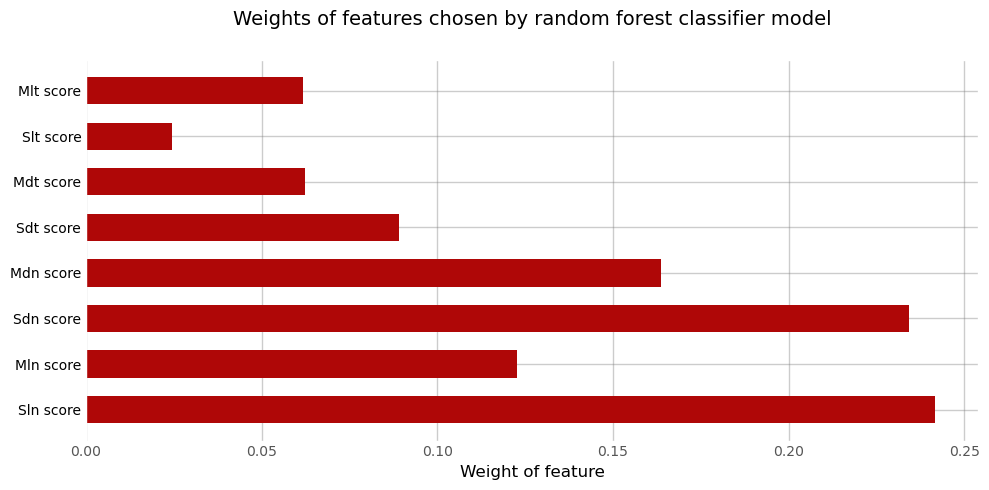

In [158]:
from pickle import load

rfc = load(open('./model.dump', 'rb'))

plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
coordinate = 0
labels = []
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
y_pos = []
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')
feature_names = ['Sln score', 'Mln score', 'Sdn score', 'Mdn score', 'Sdt score', 'Mdt score', 'Slt score', 'Mlt score']

for feature, wigth in zip(feature_names, rfc.feature_importances_):
   # print(feature, wigth)
    labels.append(feature)
    ax.barh(coordinate, wigth, height=0.3, color='#AF0707')

    y_pos.append(coordinate)
    coordinate += 0.5
    
ax.grid(color='grey', alpha=0.4)
ax.set_axisbelow(True)
ax.set_facecolor('white')
ax.set_yticks(y_pos)
ax.set_xlabel('Weight of feature', color='black')
ax.set_yticklabels(feature_names, color='black')#, rotation=90, rotation_mode="anchor")
ax.set_title("Weights of features chosen by random forest classifier model", fontsize=14, pad=25)
fig.patch.set_facecolor('white')
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig('./Features_Weight.pdf')
plt.show()